In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from tqdm import tqdm
from tsnecuda import TSNE
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "resnet50_vicreg_ce"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM_species"
ood = "0:2:3"


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 42153 images
Dataset type val label type: species


Loaded 5269 images
Dataset type test label type: species


Loaded 5270 images
Dataset type test label type: species


Loaded 43520 images


In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

0:2:3 0qzdskm4


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-0qzdskm4:best, 314.55MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:6.6


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_ftr = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []

    val_inp = []
    val_ftr = []
    val_emb = []
    val_lgt = []
    val_tgt = []

    ind_inp = []
    ind_ftr = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_ftr = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []

    rnd_inp = []
    rnd_ftr = []
    rnd_emb = []
    rnd_lgt = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_ftr.extend(ftr.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_ftr.extend(ftr.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_ftr.extend(ftr.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            ftr, emb, lgt = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_ftr.extend(ftr.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_ftr.extend(ftr.detach().cpu().numpy())
        rnd_emb.extend(emb.detach().cpu().numpy())
        rnd_lgt.extend(lgt.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                                                                             | 0/330 [00:00<?, ?it/s]

  0%|▍                                                                                                                                                    | 1/330 [00:00<03:00,  1.83it/s]

  2%|██▋                                                                                                                                                  | 6/330 [00:00<00:28, 11.44it/s]

  3%|████▉                                                                                                                                               | 11/330 [00:00<00:16, 19.93it/s]

  5%|███████▏                                                                                                                                            | 16/330 [00:00<00:11, 26.97it/s]

  6%|█████████▍                                                                                                                                          | 21/330 [00:00<00:09, 32.69it/s]

  8%|███████████▋                                                                                                                                        | 26/330 [00:01<00:08, 37.13it/s]

  9%|█████████████▉                                                                                                                                      | 31/330 [00:01<00:07, 40.52it/s]

 11%|████████████████▏                                                                                                                                   | 36/330 [00:01<00:06, 43.07it/s]

 12%|██████████████████▍                                                                                                                                 | 41/330 [00:01<00:06, 44.95it/s]

 14%|████████████████████▋                                                                                                                               | 46/330 [00:01<00:06, 46.30it/s]

 15%|██████████████████████▊                                                                                                                             | 51/330 [00:01<00:05, 47.23it/s]

 17%|█████████████████████████                                                                                                                           | 56/330 [00:01<00:05, 47.71it/s]

 18%|███████████████████████████▎                                                                                                                        | 61/330 [00:01<00:05, 48.11it/s]

 20%|█████████████████████████████▌                                                                                                                      | 66/330 [00:01<00:05, 48.53it/s]

 22%|███████████████████████████████▊                                                                                                                    | 71/330 [00:01<00:05, 48.79it/s]

 23%|██████████████████████████████████                                                                                                                  | 76/330 [00:02<00:05, 49.00it/s]

 25%|████████████████████████████████████▎                                                                                                               | 81/330 [00:02<00:05, 49.17it/s]

 26%|██████████████████████████████████████▌                                                                                                             | 86/330 [00:02<00:04, 49.24it/s]

 28%|████████████████████████████████████████▊                                                                                                           | 91/330 [00:02<00:04, 49.34it/s]

 29%|███████████████████████████████████████████                                                                                                         | 96/330 [00:02<00:04, 49.39it/s]

 31%|████████████████████████████████████████████▉                                                                                                      | 101/330 [00:02<00:04, 49.44it/s]

 32%|███████████████████████████████████████████████▏                                                                                                   | 106/330 [00:02<00:04, 49.47it/s]

 34%|█████████████████████████████████████████████████▍                                                                                                 | 111/330 [00:02<00:04, 49.43it/s]

 35%|███████████████████████████████████████████████████▋                                                                                               | 116/330 [00:02<00:04, 49.45it/s]

 37%|█████████████████████████████████████████████████████▉                                                                                             | 121/330 [00:02<00:04, 49.38it/s]

 38%|████████████████████████████████████████████████████████▏                                                                                          | 126/330 [00:03<00:04, 49.45it/s]

 40%|██████████████████████████████████████████████████████████▎                                                                                        | 131/330 [00:03<00:04, 49.47it/s]

 41%|████████████████████████████████████████████████████████████▌                                                                                      | 136/330 [00:03<00:03, 49.44it/s]

 43%|██████████████████████████████████████████████████████████████▊                                                                                    | 141/330 [00:03<00:03, 49.43it/s]

 44%|█████████████████████████████████████████████████████████████████                                                                                  | 146/330 [00:03<00:03, 49.45it/s]

 46%|███████████████████████████████████████████████████████████████████▎                                                                               | 151/330 [00:03<00:03, 49.47it/s]

 47%|█████████████████████████████████████████████████████████████████████▍                                                                             | 156/330 [00:03<00:03, 49.50it/s]

 49%|███████████████████████████████████████████████████████████████████████▋                                                                           | 161/330 [00:03<00:03, 49.51it/s]

 50%|█████████████████████████████████████████████████████████████████████████▉                                                                         | 166/330 [00:03<00:03, 49.52it/s]

 52%|████████████████████████████████████████████████████████████████████████████▏                                                                      | 171/330 [00:04<00:03, 49.46it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▍                                                                    | 176/330 [00:04<00:03, 49.32it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▋                                                                  | 181/330 [00:04<00:03, 49.39it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▊                                                                | 186/330 [00:04<00:02, 49.42it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████                                                              | 191/330 [00:04<00:02, 49.45it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▎                                                           | 196/330 [00:04<00:02, 49.45it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 201/330 [00:04<00:02, 49.47it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 206/330 [00:04<00:02, 49.46it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 211/330 [00:04<00:02, 49.44it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 216/330 [00:04<00:02, 49.45it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 221/330 [00:05<00:02, 49.43it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 226/330 [00:05<00:02, 49.43it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 231/330 [00:05<00:02, 49.47it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 236/330 [00:05<00:01, 49.33it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 241/330 [00:05<00:01, 49.17it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 246/330 [00:05<00:01, 49.27it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 251/330 [00:05<00:01, 49.42it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 256/330 [00:05<00:01, 49.45it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 261/330 [00:05<00:01, 49.48it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 266/330 [00:05<00:01, 49.47it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 271/330 [00:06<00:01, 49.50it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 276/330 [00:06<00:01, 49.53it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 281/330 [00:06<00:00, 49.39it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 287/330 [00:06<00:00, 49.75it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 292/330 [00:06<00:00, 49.55it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 297/330 [00:06<00:00, 49.52it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 302/330 [00:06<00:00, 49.51it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 307/330 [00:06<00:00, 49.47it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 312/330 [00:06<00:00, 49.42it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 317/330 [00:06<00:00, 49.38it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 322/330 [00:07<00:00, 49.26it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 328/330 [00:07<00:00, 49.60it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 330/330 [00:07<00:00, 45.44it/s]

train - OK


  0%|                                                                                                                                                              | 0/42 [00:00<?, ?it/s]

  2%|███▌                                                                                                                                                  | 1/42 [00:00<00:04,  8.46it/s]

 14%|█████████████████████▍                                                                                                                                | 6/42 [00:00<00:01, 30.87it/s]

 26%|███████████████████████████████████████                                                                                                              | 11/42 [00:00<00:00, 39.03it/s]

 38%|████████████████████████████████████████████████████████▊                                                                                            | 16/42 [00:00<00:00, 43.10it/s]

 50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 21/42 [00:00<00:00, 45.44it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 26/42 [00:00<00:00, 46.85it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 31/42 [00:00<00:00, 47.78it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 36/42 [00:00<00:00, 48.45it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 41/42 [00:00<00:00, 48.75it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:01<00:00, 41.99it/s]

val - OK


  0%|                                                                                                                                                              | 0/42 [00:00<?, ?it/s]

  2%|███▌                                                                                                                                                  | 1/42 [00:00<00:04,  8.66it/s]

 14%|█████████████████████▍                                                                                                                                | 6/42 [00:00<00:01, 30.91it/s]

 26%|███████████████████████████████████████                                                                                                              | 11/42 [00:00<00:00, 39.01it/s]

 38%|████████████████████████████████████████████████████████▊                                                                                            | 16/42 [00:00<00:00, 42.99it/s]

 50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 21/42 [00:00<00:00, 45.24it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 26/42 [00:00<00:00, 46.59it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 31/42 [00:00<00:00, 47.48it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 36/42 [00:00<00:00, 48.03it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 41/42 [00:00<00:00, 48.53it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:01<00:00, 41.87it/s]

test InD - OK


  0%|                                                                                                                                                             | 0/340 [00:00<?, ?it/s]

  0%|▍                                                                                                                                                    | 1/340 [00:00<00:41,  8.15it/s]

  2%|██▋                                                                                                                                                  | 6/340 [00:00<00:11, 30.14it/s]

  3%|████▊                                                                                                                                               | 11/340 [00:00<00:08, 38.53it/s]

  5%|██████▉                                                                                                                                             | 16/340 [00:00<00:07, 42.77it/s]

  6%|█████████▏                                                                                                                                          | 21/340 [00:00<00:07, 45.25it/s]

  8%|███████████▎                                                                                                                                        | 26/340 [00:00<00:06, 46.68it/s]

  9%|█████████████▍                                                                                                                                      | 31/340 [00:00<00:06, 47.53it/s]

 11%|███████████████▋                                                                                                                                    | 36/340 [00:00<00:06, 48.15it/s]

 12%|█████████████████▊                                                                                                                                  | 41/340 [00:00<00:06, 48.63it/s]

 14%|████████████████████                                                                                                                                | 46/340 [00:01<00:06, 48.94it/s]

 15%|██████████████████████▏                                                                                                                             | 51/340 [00:01<00:05, 49.15it/s]

 16%|████████████████████████▍                                                                                                                           | 56/340 [00:01<00:05, 49.33it/s]

 18%|██████████████████████████▌                                                                                                                         | 61/340 [00:01<00:05, 49.42it/s]

 19%|████████████████████████████▋                                                                                                                       | 66/340 [00:01<00:05, 49.50it/s]

 21%|██████████████████████████████▉                                                                                                                     | 71/340 [00:01<00:05, 49.53it/s]

 22%|█████████████████████████████████                                                                                                                   | 76/340 [00:01<00:05, 49.53it/s]

 24%|███████████████████████████████████▎                                                                                                                | 81/340 [00:01<00:05, 49.57it/s]

 25%|█████████████████████████████████████▍                                                                                                              | 86/340 [00:01<00:05, 49.52it/s]

 27%|███████████████████████████████████████▌                                                                                                            | 91/340 [00:01<00:05, 49.44it/s]

 28%|█████████████████████████████████████████▊                                                                                                          | 96/340 [00:02<00:04, 49.48it/s]

 30%|███████████████████████████████████████████▋                                                                                                       | 101/340 [00:02<00:04, 49.50it/s]

 31%|█████████████████████████████████████████████▊                                                                                                     | 106/340 [00:02<00:04, 49.52it/s]

 33%|███████████████████████████████████████████████▉                                                                                                   | 111/340 [00:02<00:04, 49.55it/s]

 34%|██████████████████████████████████████████████████▏                                                                                                | 116/340 [00:02<00:04, 49.60it/s]

 36%|████████████████████████████████████████████████████▎                                                                                              | 121/340 [00:02<00:04, 49.63it/s]

 37%|██████████████████████████████████████████████████████▍                                                                                            | 126/340 [00:02<00:04, 49.65it/s]

 39%|████████████████████████████████████████████████████████▋                                                                                          | 131/340 [00:02<00:04, 49.69it/s]

 40%|██████████████████████████████████████████████████████████▊                                                                                        | 136/340 [00:02<00:04, 49.55it/s]

 41%|████████████████████████████████████████████████████████████▉                                                                                      | 141/340 [00:02<00:04, 49.62it/s]

 43%|███████████████████████████████████████████████████████████████                                                                                    | 146/340 [00:03<00:03, 49.51it/s]

 44%|█████████████████████████████████████████████████████████████████▎                                                                                 | 151/340 [00:03<00:03, 49.57it/s]

 46%|███████████████████████████████████████████████████████████████████▍                                                                               | 156/340 [00:03<00:03, 49.57it/s]

 47%|█████████████████████████████████████████████████████████████████████▌                                                                             | 161/340 [00:03<00:03, 49.63it/s]

 49%|███████████████████████████████████████████████████████████████████████▊                                                                           | 166/340 [00:03<00:03, 49.66it/s]

 50%|█████████████████████████████████████████████████████████████████████████▉                                                                         | 171/340 [00:03<00:03, 49.68it/s]

 52%|████████████████████████████████████████████████████████████████████████████                                                                       | 176/340 [00:03<00:03, 49.69it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▎                                                                    | 181/340 [00:03<00:03, 49.70it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▍                                                                  | 186/340 [00:03<00:03, 49.69it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▌                                                                | 191/340 [00:03<00:03, 49.54it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▋                                                              | 196/340 [00:04<00:02, 49.56it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▉                                                            | 201/340 [00:04<00:02, 49.63it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████                                                          | 206/340 [00:04<00:02, 49.55it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 211/340 [00:04<00:02, 49.60it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 216/340 [00:04<00:02, 49.66it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 221/340 [00:04<00:02, 49.67it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 226/340 [00:04<00:02, 49.67it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 231/340 [00:04<00:02, 49.68it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 236/340 [00:04<00:02, 49.72it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 241/340 [00:04<00:01, 49.72it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 246/340 [00:05<00:01, 49.75it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 251/340 [00:05<00:01, 49.76it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 257/340 [00:05<00:01, 49.83it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 263/340 [00:05<00:01, 49.92it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 268/340 [00:05<00:01, 49.79it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 274/340 [00:05<00:01, 49.91it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 280/340 [00:05<00:01, 49.99it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 286/340 [00:05<00:01, 50.24it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 292/340 [00:05<00:00, 50.30it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 298/340 [00:06<00:00, 50.23it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 304/340 [00:06<00:00, 50.31it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 310/340 [00:06<00:00, 50.38it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 316/340 [00:06<00:00, 50.33it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 322/340 [00:06<00:00, 50.40it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 328/340 [00:06<00:00, 50.40it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 334/340 [00:06<00:00, 50.47it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 340/340 [00:06<00:00, 50.23it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 340/340 [00:06<00:00, 48.81it/s]

test OoD - OK


  0%|                                                                                                                                                             | 0/100 [00:00<?, ?it/s]

  6%|████████▉                                                                                                                                            | 6/100 [00:00<00:01, 52.85it/s]

 12%|█████████████████▊                                                                                                                                  | 12/100 [00:00<00:01, 52.16it/s]

 18%|██████████████████████████▋                                                                                                                         | 18/100 [00:00<00:01, 52.02it/s]

 24%|███████████████████████████████████▌                                                                                                                | 24/100 [00:00<00:01, 51.95it/s]

 30%|████████████████████████████████████████████▍                                                                                                       | 30/100 [00:00<00:01, 51.90it/s]

 36%|█████████████████████████████████████████████████████▎                                                                                              | 36/100 [00:00<00:01, 51.91it/s]

 42%|██████████████████████████████████████████████████████████████▏                                                                                     | 42/100 [00:00<00:01, 51.92it/s]

 48%|███████████████████████████████████████████████████████████████████████                                                                             | 48/100 [00:00<00:01, 51.94it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▉                                                                    | 54/100 [00:01<00:00, 51.96it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 60/100 [00:01<00:00, 51.97it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 66/100 [00:01<00:00, 51.96it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 72/100 [00:01<00:00, 51.97it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 78/100 [00:01<00:00, 51.96it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 84/100 [00:01<00:00, 51.95it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 90/100 [00:01<00:00, 51.95it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 96/100 [00:01<00:00, 51.97it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 51.97it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_ftr = np.array(trn_ftr).squeeze()
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt) 

val_inp = np.array(val_inp)
val_ftr = np.array(val_ftr).squeeze()
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_ftr = np.array(ind_ftr).squeeze()
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_ftr = np.array(ood_ftr).squeeze()
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_ftr = np.array(rnd_ftr).squeeze()
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_ftr.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_ftr.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_ftr.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_ftr.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_ftr.shape, rnd_emb.shape, rnd_lgt.shape)

(42153, 3, 64, 64) (42153, 2048) (42153, 512) (42153, 2) (42153,)
(5269, 3, 64, 64) (5269, 2048) (5269, 512) (5269, 2) (5269,)
(5270, 3, 64, 64) (5270, 2048) (5270, 512) (5270, 2) (5270,)
(43520, 3, 64, 64) (43520, 2048) (43520, 512) (43520, 2) (43520,)
(12800, 3, 64, 64) (12800, 2048) (12800, 512) (12800, 2)


In [11]:
# create tsne embeddings
n = ind_ftr.shape[0]
all_ftr = ind_ftr
all_lgt = ind_lgt
if ood_str:
    all_ftr = np.concatenate([all_ftr, ood_ftr], axis=0)
    all_lgt = np.concatenate([all_lgt, ood_lgt], axis=0)

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
all_ftr2d = tsne.fit_transform(all_ftr)
ind_ftr2d = np.array(all_ftr2d[:n], order='C').astype(np.float32)
ood_ftr2d = np.array(all_ftr2d[n:], order='C').astype(np.float32)
print(ind_ftr2d.shape, ood_ftr2d.shape)

if all_lgt.shape[-1] > 2:
    tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
    lgt2d = tsne.fit_transform(all_lgt)
else:
    lgt2d = all_lgt
ind_lgt2d = np.array(lgt2d[:n], order='C').astype(np.float32)
ood_lgt2d = np.array(lgt2d[n:], order='C').astype(np.float32)
print(ind_lgt2d.shape, ood_lgt2d.shape)

(5270, 2) (43520, 2)
(5270, 2) (43520, 2)


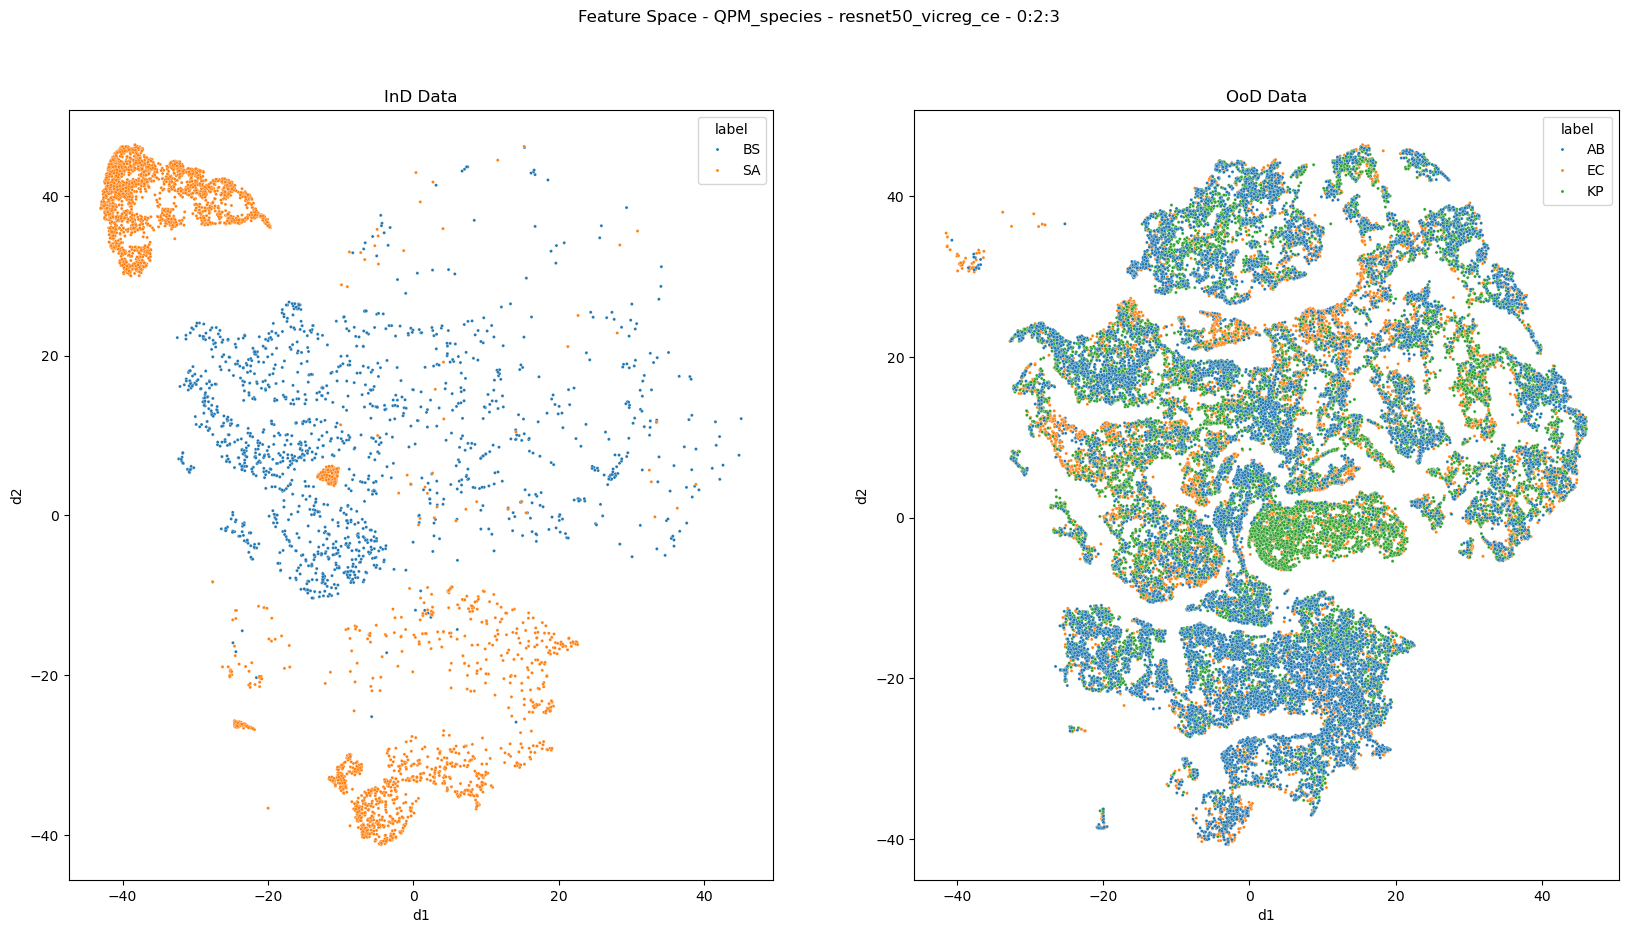

In [12]:
# plot feature space
df_ftr2d = pd.DataFrame()
d1, d2 = ind_ftr2d.T
df_ftr2d = pd.concat([df_ftr2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_ftr2d.T
    df_ftr2d = pd.concat([df_ftr2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_ftr2d[(df_ftr2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_ftr2d[(df_ftr2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

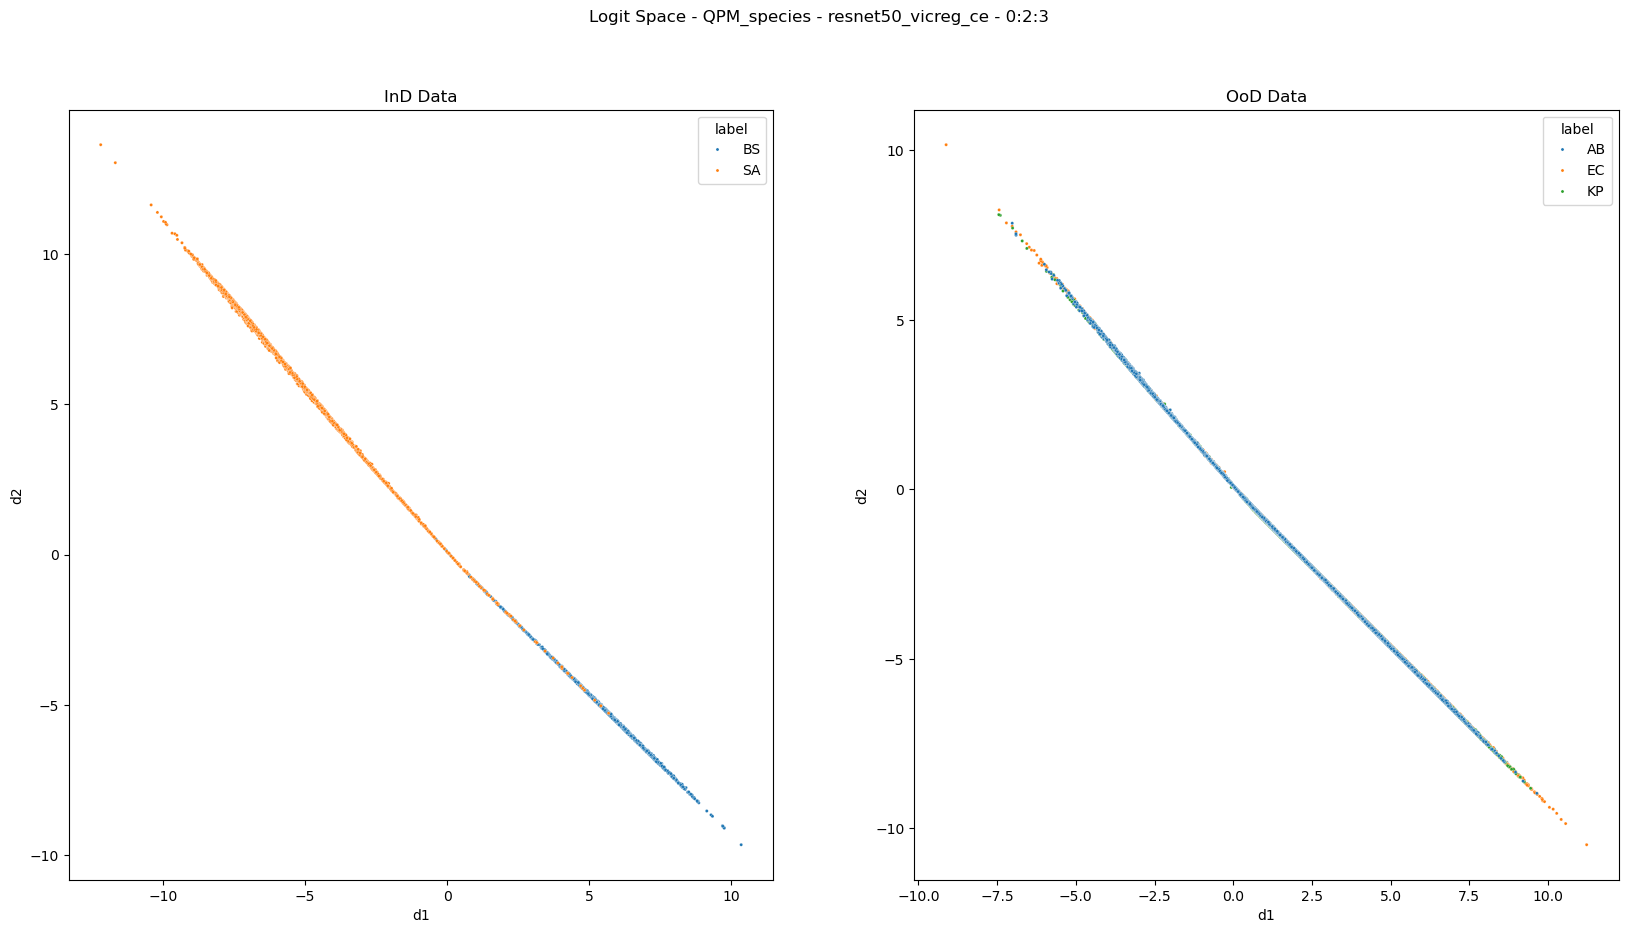

In [13]:
# plot logit space
df_lgt2d = pd.DataFrame()
d1, d2 = ind_lgt2d.T
df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt2d.T
    df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

  0%|                                                                                                                                                               | 0/4 [00:00<?, ?it/s]

 25%|█████████████████████████████████████▊                                                                                                                 | 1/4 [00:06<00:20,  6.75s/it]

 50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 2/4 [00:13<00:13,  6.69s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 3/4 [00:20<00:06,  6.72s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:27<00:00,  6.87s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:27<00:00,  6.82s/it]

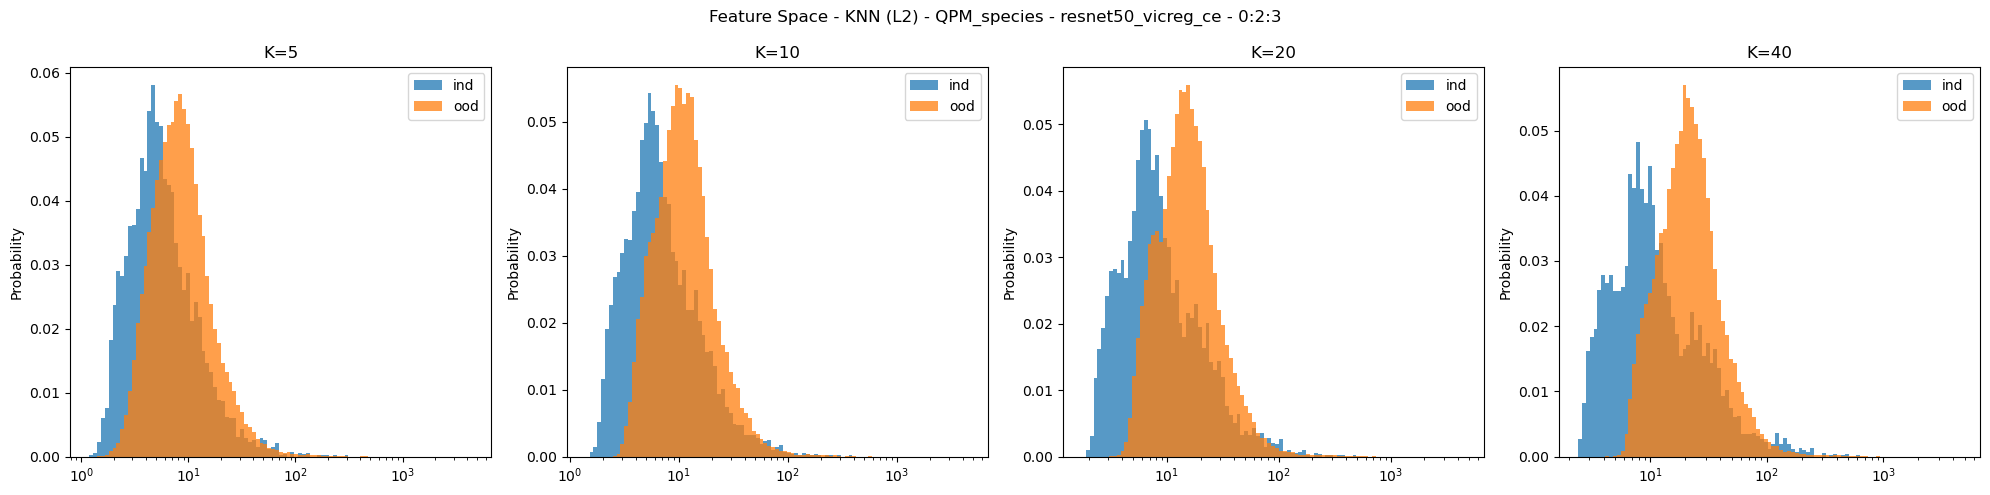

In [14]:
# plot knn to val data in feature space (L2)
index = faiss.IndexFlatL2(ind_ftr.shape[-1])
index.add(val_ftr)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_ftr, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_ftr, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                                               | 0/4 [00:00<?, ?it/s]

 25%|█████████████████████████████████████▊                                                                                                                 | 1/4 [00:06<00:19,  6.53s/it]

 50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 2/4 [00:13<00:13,  6.64s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 3/4 [00:19<00:06,  6.66s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:27<00:00,  6.83s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:27<00:00,  6.75s/it]

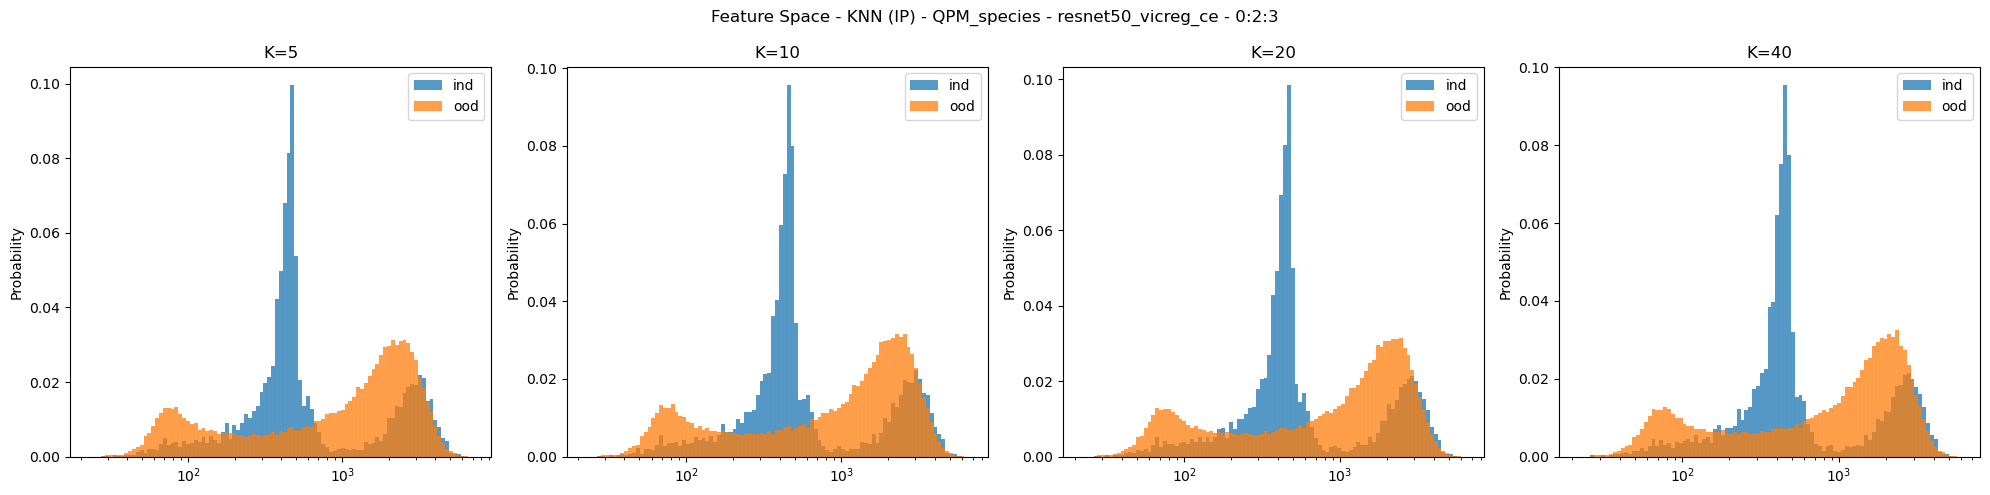

In [15]:
# plot knn to val data in feature space (IP)
index = faiss.IndexFlatIP(ind_ftr.shape[-1])
index.add(val_ftr)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_ftr, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_ftr, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                                               | 0/4 [00:00<?, ?it/s]

 25%|█████████████████████████████████████▊                                                                                                                 | 1/4 [00:00<00:01,  2.73it/s]

 50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 2/4 [00:00<00:00,  2.59it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 3/4 [00:01<00:00,  2.33it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  1.93it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.10it/s]

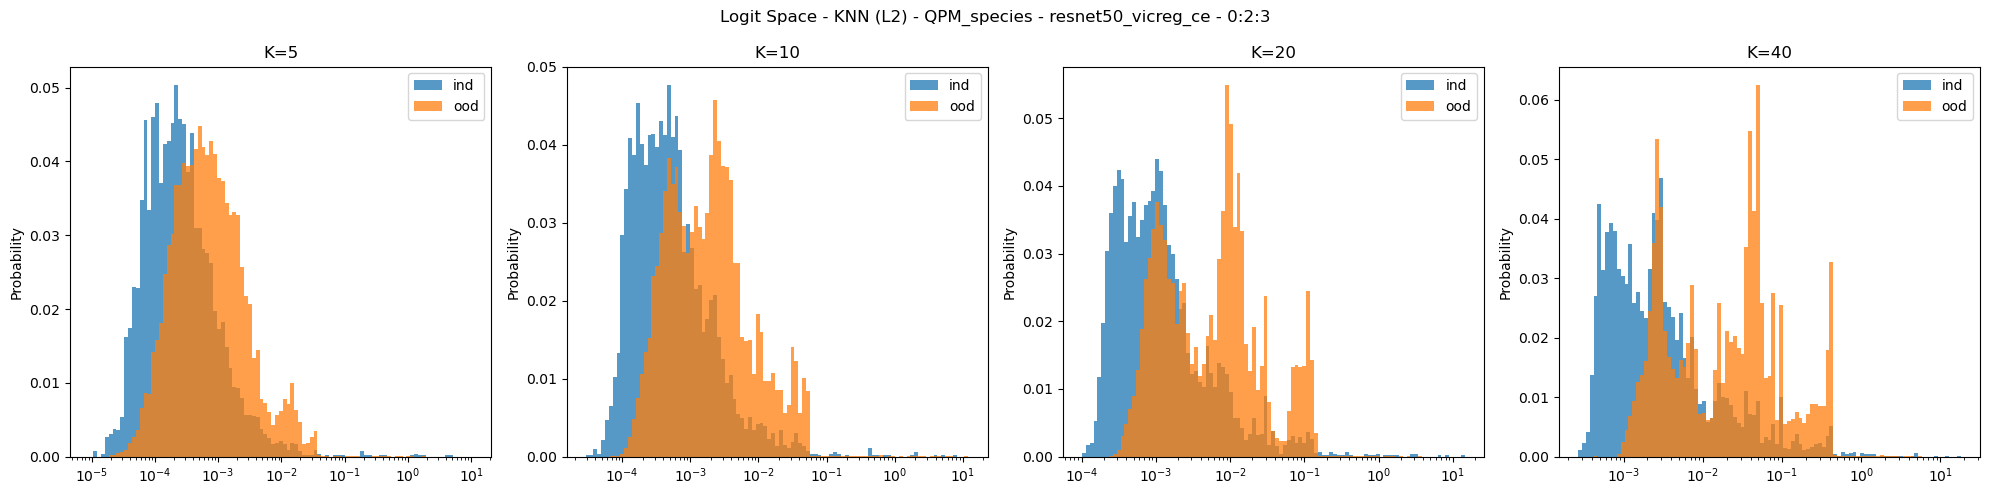

In [16]:
# plot knn to val data in logit space (L2)
index = faiss.IndexFlatL2(ind_lgt.shape[-1])
index.add(val_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                                               | 0/4 [00:00<?, ?it/s]

 25%|█████████████████████████████████████▊                                                                                                                 | 1/4 [00:00<00:00,  3.10it/s]

 50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 2/4 [00:00<00:00,  3.05it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 3/4 [00:01<00:00,  2.94it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.70it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.80it/s]

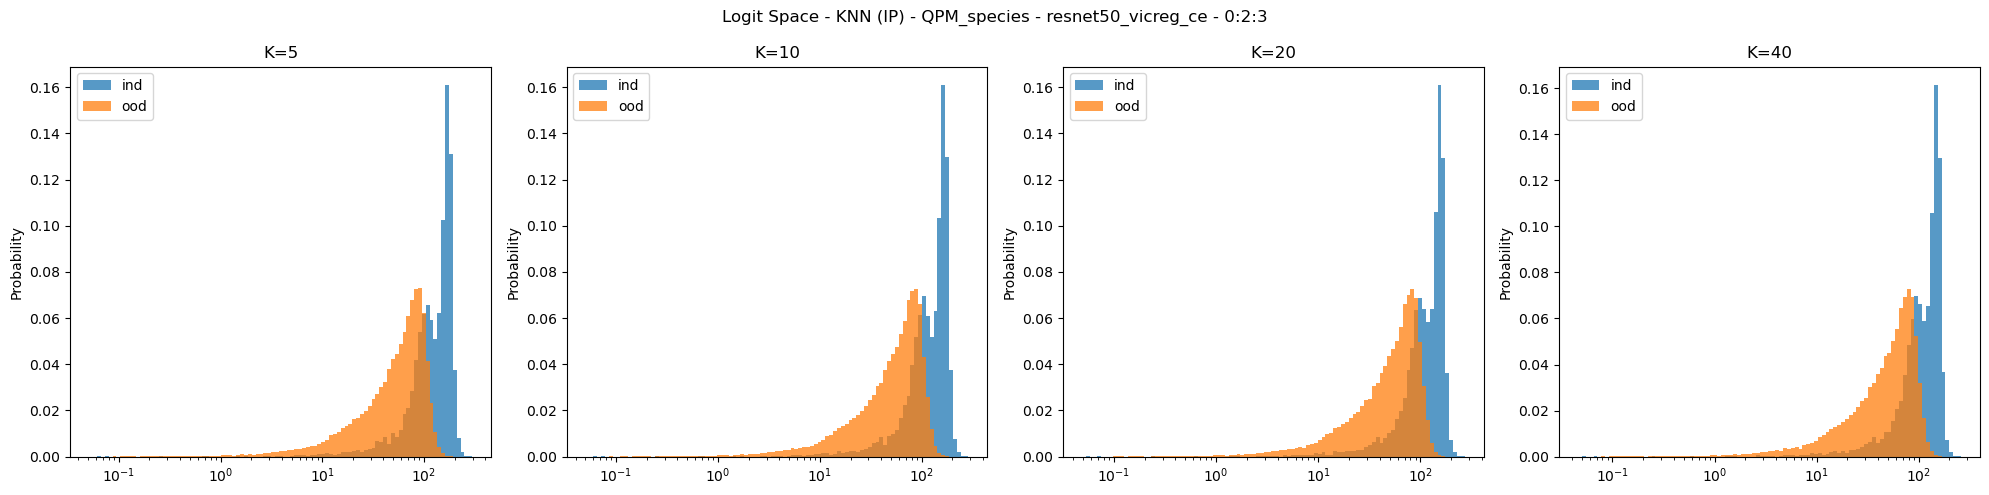

In [17]:
# plot knn to val data in logit space (IP)
index = faiss.IndexFlatIP(ind_lgt.shape[-1])
index.add(val_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

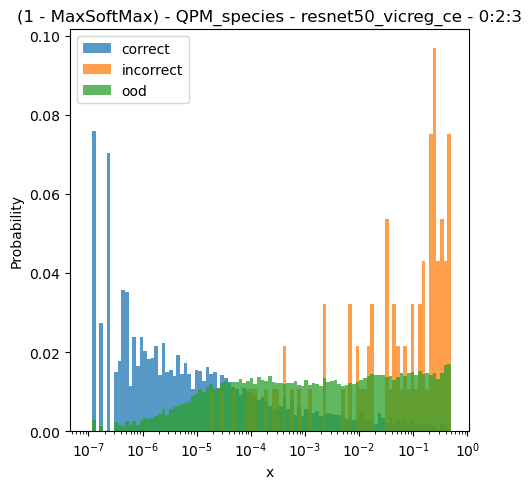

In [18]:
# plot (1 - maxsoftmax) distribution
ind_prob = np.exp(ind_lgt) / np.exp(ind_lgt).sum(-1, keepdims=True)
ind_pred = ind_prob.argmax(-1)
ind_ucty = -ind_prob.max(-1) + 1.0

if ood_str:
    ood_prob = np.exp(ood_lgt) / np.exp(ood_lgt).sum(-1, keepdims=True)
    ood_pred = ood_prob.argmax(-1)
    ood_ucty = -ood_prob.max(-1) + 1.0

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.logspace(np.log10(df['x'].min() + 1e-7), np.log10(df['x'].max()), 100)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
ax.set_xscale("log")
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()